In [1]:
### Import needed libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.isotonic import IsotonicRegression
from matplotlib.collections import LineCollection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model

### Objective: To understnd the relationship between UW energy price vs All energy acquistion

* Read the data
* Make changes to column names

In [2]:
df = pd.read_csv("scatter_df.csv")

In [3]:
df.columns = df.columns.str.lower()
df.columns = df.columns. str. replace(' ','_')
df = df.drop('unnamed:_0', axis =1)

In [4]:
df.shape

(993, 4)

In [5]:
df.head()

,ds,customers_acquired,week,partners_acquired
0,2021-09-26,195,38,3.465736
1,2021-09-25,201,38,3.091042
2,2021-09-24,391,38,3.912023
3,2021-09-23,429,38,3.871201
4,2021-09-22,333,38,3.688879


### The data has only one missing value for August 2021 we will remove that for now

In [6]:
train = df[df.notna()]
train.shape

(993, 4)

### Scatter plots between X's and y's

```
X: uw_cheapest_energy_price_(£), market_cheapest
Y: all_energy_uw_customers_acquired, total_market_churn
  
X,y pairs = (uw_cheapest_energy_price_(£), all_energy_uw_customers_acquired)
            (market_cheapest, all_energy_uw_customers_acquired)
            (market_cheapest, total_market_churn)
            (delta_with_cheapest_price_in_the_market_(£),all_energy_uw_customers_acquired)
```

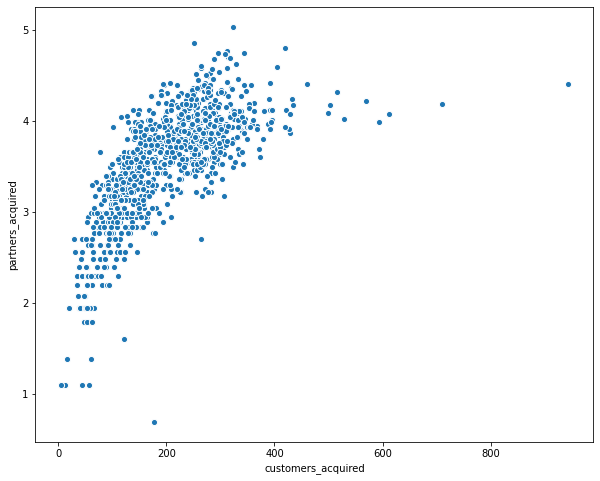

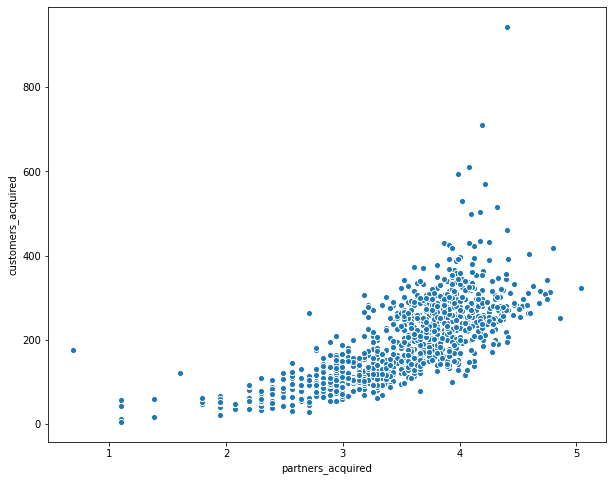

In [7]:
def create_scatter_plot(data, var1, var2):
    fig, ax = plt.subplots(nrows=1 , figsize=(10, 8))
    ax.scatter(data[var1], data[var2], s=38, edgecolors='white')
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)

create_scatter_plot(train,"customers_acquired", "partners_acquired" )
create_scatter_plot(train,"partners_acquired", "customers_acquired" )

#### Correlation Matrix

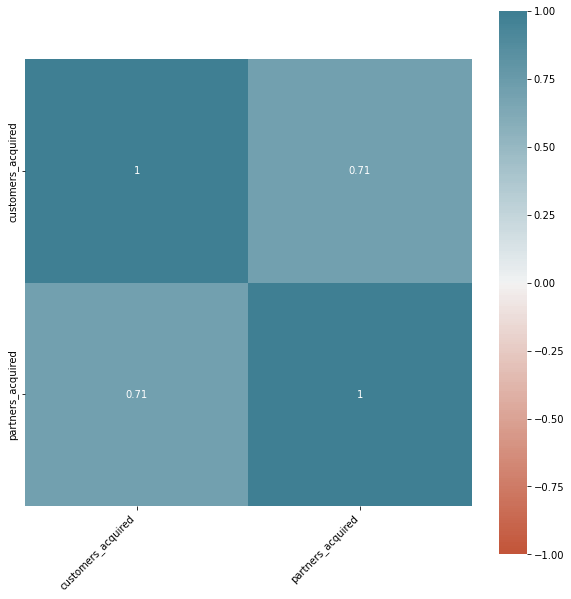

In [8]:
corr = train[['customers_acquired', 'partners_acquired']].corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Lets Fit a linear and Isotonic regression on UW energy price and customers acquired

In [9]:
def lr_and_isotonic(data, var1, var2):
    '''X: UW cheapest energy price, market cheapest
       y: UW customers acquired, total market churn
       Sorted on X (sorting only helps with plots)
       X,y pairs = (UW cheapest energy price, UW customers acquired)
                   (market cheapest, UW customers acquired)
                   (market cheapest, total market churn)
    '''
    
    X = data[[var1, var2]].sort_values(var1)[var1]
    y = data[[var1, var2]].sort_values(var1)[var2]
    X, y = np.array(X), np.array(y)
    
    '''Linear Regression, fitting , prediction, intercept, coefficients and scores'''
    lr = LinearRegression().fit(X[:, np.newaxis], y)
    pred_lr = lr.predict(X[:, np.newaxis])
    intercept= lr.intercept_
    slope = lr.coef_
    r2_score_lr = r2_score(y, pred_lr)
    RMSE_lr = mean_squared_error(y, pred_lr, squared=True)
    
    '''Isotonic regression, prediction and scores'''
    isor = IsotonicRegression().fit(X, y)
    pred_isor = isor.predict(X)
    r2_score_isor = r2_score(y, pred_isor)
    RMSE_isor = mean_squared_error(y, pred_isor, squared=True)
    
    '''Dictionary with all results from above '''
    result = {"isor": isor,
              "lr": lr,
              "X": X,
              "y": y,
              "pred_lr": pred_lr,
              "pred_isor": pred_isor,
              "r2_score_lr":r2_score_lr,
              "r2_score_isor":r2_score_isor,
              "RMSE_lr":RMSE_lr,
              "RMSE_isor":RMSE_isor,
              "intercept":intercept,
              "slope":slope
             }
    return result

In [10]:
def plot_lr_isotonic(result, title, xlabel, ylabel):
    ''' Fetch all values from result and enlist them
    '''
    n = train.shape[0]
    predictor = result['X']
    target = result['y']
    lr = result['lr']
    prediction = result['pred_isor']
    
    ''' Below lines of code creates a collection of lines which will mark thresholds from every point
    '''
    segments = [[[predictor[i], target[i]], [predictor[i], prediction[i]]] for i in range(n)]
    lc = LineCollection(segments, zorder=0)    
    lc.set_array(np.ones(len(target)))
    lc.set_linewidths(np.full(n, 0.5))
     
    '''  Create a plot with linear, isotonic and threshhold
    '''
    fig, (ax) = plt.subplots(ncols=1, figsize=(12, 6))

    ax.plot(predictor, target, 'C0.', markersize=7)
    ax.plot(predictor, prediction, 'C1.-', markersize=7)
    ax.plot(predictor, lr.predict(predictor[:, np.newaxis]), 'C2-')
    ax.add_collection(lc)
    ax.legend(('Training data', 'Isotonic fit', 'Linear fit'), loc='upper left')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return (ax)

In [11]:
'''Print coefficient of determination adn RMSE'''
def print_metrics(scores):
    print("Linear Regression")
    print("R2 = ", "{:.7f}".format(scores['r2_score_lr']), "RMSE = ", scores['RMSE_lr'], "Intercept = ", round(scores['intercept'],2), "Slope = ", round(scores['slope'][0],3))
    print("Isotnic Regression")
    print("R2 = ", "{:.7f}".format(scores['r2_score_isor']), "RMSE = ", scores['RMSE_isor'])

### X: #customers    y: #partners

In [12]:
train.head()

,ds,customers_acquired,week,partners_acquired
0,2021-09-26,195,38,3.465736
1,2021-09-25,201,38,3.091042
2,2021-09-24,391,38,3.912023
3,2021-09-23,429,38,3.871201
4,2021-09-22,333,38,3.688879


In [13]:
customers_partners = lr_and_isotonic(train, 'customers_acquired','partners_acquired' )
print_metrics(customers_partners)

Linear Regression
R2 =  0.5021227 RMSE =  0.17927394275834127 Intercept =  2.65 Slope =  0.004
Isotnic Regression
R2 =  0.6800595 RMSE =  0.11520309841315032


<AxesSubplot:title={'center':'Customer Acquisition vs Partner Acquired'}, xlabel='#Customers', ylabel='#Partners acquired'>

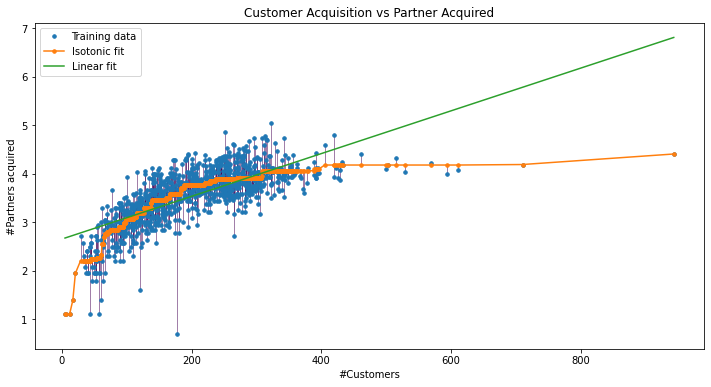

In [14]:
plot_lr_isotonic(customers_partners, "Customer Acquisition vs Partner Acquired", "#Customers", "#Partners acquired")

#### Customer acquisition vs Partners Acquired

* If customer acqusition is increasing from ~50-300, partner acquisition increases from ~2-4
* After 4 partners, there is not significant change in partner acquisition despite of increase customer acquisition
* Please note that instances with more than 400 customers are quite less

In [15]:
patners_customers = lr_and_isotonic(train, 'partners_acquired','customers_acquired' )
print_metrics(patners_customers)

Linear Regression
R2 =  0.5021227 RMSE =  4624.689011891767 Intercept =  -201.36 Slope =  113.812
Isotnic Regression
R2 =  0.5543158 RMSE =  4139.877392608689


<AxesSubplot:title={'center':'Partner Acquisition vs Customers Acquired'}, xlabel='#Partners', ylabel='#Customers acquired'>

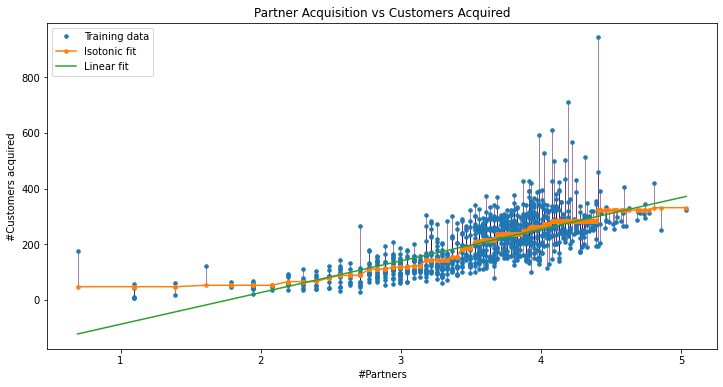

In [16]:
plot_lr_isotonic(patners_customers, "Partner Acquisition vs Customers Acquired", "#Partners", "#Customers acquired")

#### Partner acquisition vs Customers Acquired

* Increae from 2 to 4 partners has ~250 customer increment(from 50 to 300 approximately)
* After 4 partners, acquisition in customers has no significant change.